In [1]:
import os
import sys
sys.path.append(os.path.abspath('..'))

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import modules.rcnn.net as net
import modules.rcnn.shapes as shapes
import modules.rcnn.box as box

In [2]:
H = 20
W = 20
h = H-1
w = W-1

n_min = 2
n_max = 6

x, shap = shapes.get_random_shapes(n_min,n_max,H,W)

gt_box, gt_label = shapes.shapes_to_gt(shap)
print(gt_box)
print(gt_label)

[[0.38447746 0.83333333 0.15666667 0.15666667]
 [0.44760929 0.5        0.20987909 0.20987909]
 [0.7803552  0.16666667 0.19114875 0.31534035]]
[2. 1. 0.]


In [3]:
anchor_boxes = np.array([
    [0.3,0.3],
    [0.2,0.2],
    [0.1,0.1],
    [0.05,0.05],
])

K = anchor_boxes.shape[0]

anchors = np.zeros((H,W,K,4))

for i in range(H):
    for j in range(W):
        anchors[i,j,:,0] = (j+0.5)/W
        anchors[i,j,:,1] = (i+0.5)/H
        anchors[i,j,:,2] = anchor_boxes[:,0]
        anchors[i,j,:,3] = anchor_boxes[:,1]
        
anchors_1d = anchors.reshape((-1,4))

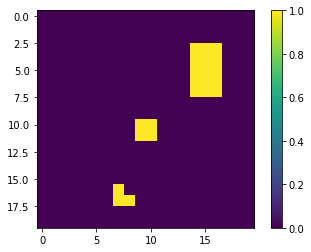

In [4]:
plt.figure()
plt.imshow(x)
plt.colorbar()
plt.show()

In [5]:
Ntrain     = 10000
lr         = 0.000001
print_step = 1000

In [6]:
x_tf       = tf.placeholder(shape=[1,H,W,1], dtype=tf.float32)
y_box_tf   = tf.placeholder(shape=[H*W*K,4], dtype=tf.float32)
y_label_tf = tf.placeholder(shape=[H*W*K], dtype=tf.float32)
y_weights_tf = tf.placeholder(shape=[H*W*K], dtype=tf.float32)

backbone = net.Backbone(input_channels=1, output_size=64)
rpn      = net.RPN(backbone, num_boxes=K, backbone_channels=64, 
                   window_size=10, hidden_size=256)

rpn_obj_logits, rpn_obj, rpn_box = rpn(x_tf)

list_box        = tf.reshape(rpn_box, shape=[-1,4])
list_obj_logits = tf.reshape(rpn_obj_logits, shape=[-1])
list_obj        = tf.reshape(rpn_obj, shape=[-1])

loss_class = tf.reduce_sum(y_weights_tf*tf.nn.sigmoid_cross_entropy_with_logits(labels=y_label_tf, 
                                         logits=list_obj_logits))

loss_box   = 10*tf.reduce_sum(y_weights_tf*y_label_tf*(tf.reduce_sum(tf.square(list_box - y_box_tf), axis=1)))

lab_sum = tf.reduce_sum(y_label_tf)

loss = loss_class+loss_box

print(loss_class, loss_box, loss)

W0812 17:25:14.806667 140419753240320 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0812 17:25:14.808340 140419753240320 deprecation_wrapper.py:119] From /home/marsdenlab/projects/centerline_detection/modules/rcnn/net.py:13: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0812 17:25:14.809085 140419753240320 deprecation_wrapper.py:119] From /home/marsdenlab/projects/centerline_detection/modules/layers_new.py:35: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0812 17:25:14.876850 140419753240320 deprecation.py:323] From /home/marsdenlab/anaconda3/lib/python3.6/site-packages/tens

Tensor("Sum:0", shape=(), dtype=float32) Tensor("mul_3:0", shape=(), dtype=float32) Tensor("add:0", shape=(), dtype=float32)


In [7]:
opt = tf.train.AdamOptimizer(lr)
train_op = opt.minimize(loss)

In [8]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [ ]:
for i in range(Ntrain):
    
    x, shap = shapes.get_random_shapes(n_min,n_max,H,W)
    
    gt_box, gt_label = shapes.shapes_to_gt(shap)
    
    gt_t, gt_matched, gt_labels, gt_weights =\
    box.create_box_gt(anchors_1d, gt_box)
    
    x = x.reshape((1,H,W,1))
    
    sess.run(train_op, {x_tf:x, y_box_tf:gt_t, y_label_tf:gt_labels, y_weights_tf:gt_weights})
    
    if i%print_step == 0:
        l,lc,lb,ls = sess.run([loss, loss_class, loss_box, lab_sum], {x_tf:x, y_box_tf:gt_t, y_label_tf:gt_labels, y_weights_tf:gt_weights})
        
        print("iteration {}: loss={:.3f} loss_class={:.3f} loss_box={:.5f}, lab_sum={:.3f}".format(i,l, lc, lb, ls))

iteration 0: loss=1076.455 loss_class=1076.455 loss_box=0.00000, lab_sum=0.000
iteration 1000: loss=691.979 loss_class=691.492 loss_box=0.48645, lab_sum=2.000
iteration 2000: loss=325.455 loss_class=324.997 loss_box=0.45858, lab_sum=3.000
iteration 3000: loss=125.210 loss_class=124.215 loss_box=0.99508, lab_sum=2.000
iteration 4000: loss=116.509 loss_class=115.986 loss_box=0.52278, lab_sum=3.000
iteration 5000: loss=37.422 loss_class=37.422 loss_box=0.00000, lab_sum=0.000
iteration 6000: loss=54.025 loss_class=53.892 loss_box=0.13337, lab_sum=1.000
iteration 7000: loss=20.120 loss_class=20.120 loss_box=0.00000, lab_sum=0.000
iteration 8000: loss=10.433 loss_class=10.433 loss_box=0.00000, lab_sum=0.000


In [10]:
x, shap = shapes.get_random_shapes(n_min,n_max,H,W)

gt_box, gt_label = shapes.shapes_to_gt(shap)

gt_t, gt_matched, gt_labels, gt_weights =\
box.create_box_gt(anchors_1d, gt_box)

x = x.reshape((1,H,W,1))

out_box, l_box, out_obj = sess.run([rpn_box, list_box, rpn_obj], {x_tf:x})

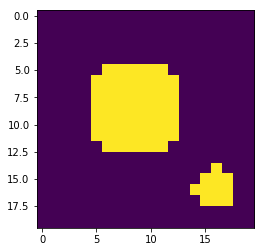

0


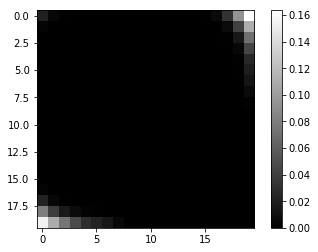

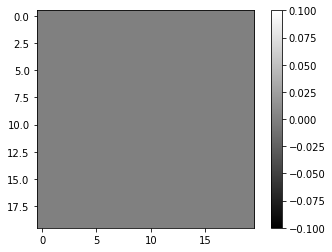

1


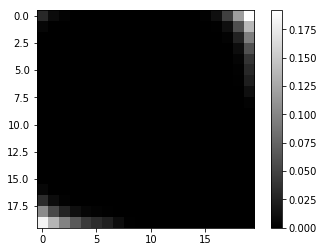

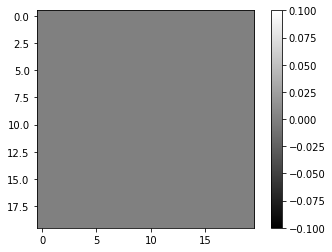

2


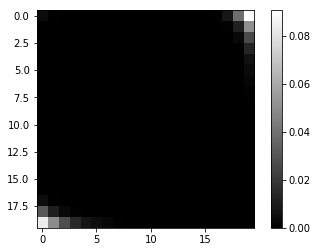

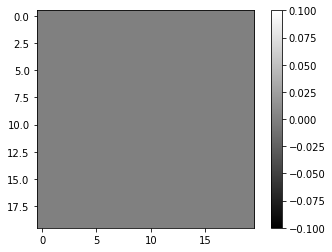

3


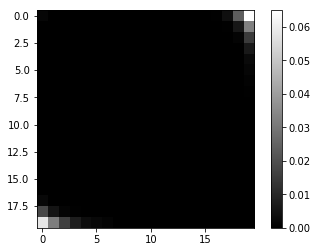

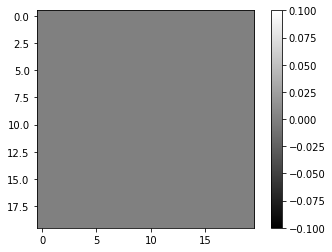

weights
0


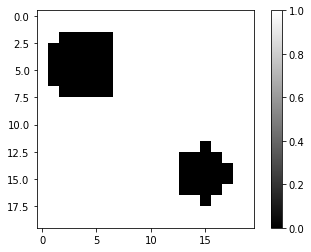

1


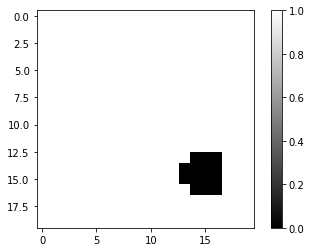

2


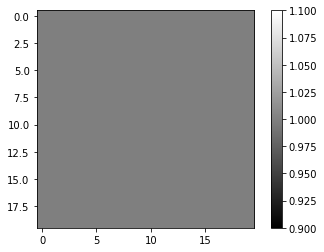

3


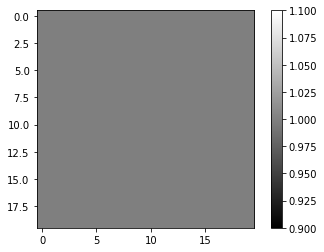

In [11]:
lab = gt_labels.reshape((H,W,K))
weights = gt_weights.reshape((H,W,K))

plt.figure()
plt.imshow(x[0,:,:,0])
plt.show()

for i in range(K):
    print(i)
    plt.figure()
    plt.imshow(out_obj[0,:,:,i], cmap='gray')
    plt.colorbar()
    plt.show()
    
    plt.figure()
    plt.imshow(lab[:,:,i], cmap='gray')
    plt.colorbar()
    plt.show()
    
print("weights")
for i in range(K):
    print(i)
    plt.figure()
    plt.imshow(weights[:,:,i], cmap='gray')
    plt.colorbar()
    plt.show()

In [12]:
predicted_boxes, predicted_obj = sess.run([list_box, list_obj],{x_tf:x})

In [14]:
anch_p = anchors.reshape((-1,4))[predicted_obj>0.1]
print(anch_p)

[[0.925 0.025 0.2   0.2  ]
 [0.975 0.025 0.3   0.3  ]
 [0.975 0.025 0.2   0.2  ]
 [0.975 0.075 0.3   0.3  ]
 [0.975 0.075 0.2   0.2  ]
 [0.025 0.925 0.2   0.2  ]
 [0.025 0.975 0.3   0.3  ]
 [0.025 0.975 0.2   0.2  ]
 [0.075 0.975 0.3   0.3  ]
 [0.075 0.975 0.2   0.2  ]]


In [17]:
bp = predicted_boxes[predicted_obj>0.1]
print(bp)

[[-0.00227138  0.00162369 -0.00333678  0.00100581]
 [-0.00303205  0.00121395  0.00046431  0.00066669]
 [-0.00233857  0.00105563 -0.00297988  0.00062524]
 [-0.00329642  0.00139976  0.00065876  0.0007082 ]
 [-0.002768    0.00129454 -0.00431031  0.00082819]
 [ 0.00217986  0.00118667 -0.0045773   0.00147786]
 [ 0.00043062  0.0001709   0.00047238  0.00043827]
 [ 0.00143882  0.00063524 -0.00342326  0.00059746]
 [ 0.00024707  0.00028204  0.00038208  0.00043771]
 [ 0.00134427  0.0006762  -0.00454193  0.00076418]]


In [16]:
print(gt_t[predicted_obj>0.5])

[]


In [16]:
bp_n = box.inv_bbox_transform(bp,anch_p)
print(bp_n)
print(gt_box)

[]
[[0.20334492 0.9        0.09       0.09      ]
 [0.60078172 0.7        0.10855121 0.16694485]
 [0.6953157  0.5        0.10089484 0.14641589]
 [0.43989551 0.3        0.15010764 0.19450328]
 [0.51722756 0.1        0.16083065 0.14020361]]
